# Multi-Scenario MORDM with worst case scenarios

In this notebook 

This notebook consist of five main steps:
1. Problem formulation 
2. A little bit of open exploration
3. Searching for the worst scenarios based on the effect of the uncertainties
4. Performing Optimalisation to find policy options that work well in these worst scenarios


## 1. Problem formulation

For Dike Ring 1, the following objectives, all to be minimized, are of interest:\
•	A.1 Expected Annual Damage\
•	A.1 Dike Investment Costs\
•	A.1 Expected Annual Number of Deaths\
•	Total Expected Annual Number of Deaths
•	Total Expected Annual Damage

For these five objectives, MORDM will be done.

## 2. Little bit of open exploration

### 2.1 Preparing the notebook file and loading in base case file

In [8]:
from ema_workbench import load_results
from ema_workbench import (Model, RealParameter, ScalarOutcome, MultiprocessingEvaluator, 
                           ema_logging, Constant, Scenario, Policy, Constraint,
                           CategoricalParameter, IntegerParameter, IntegerParameter, RealParameter,
                           perform_experiments)

from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging, utilities


from ema_workbench.em_framework.optimization import (HyperVolume, EpsilonProgress)
from ema_workbench.analysis import prim
import time
import pickle

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [10]:
#Loading in the base case file
#with this ultimately the worst cases are found
base_case_results=pd.read_csv('base_case_without_NaN.csv')
base_case_results=base_case_results.drop(columns=["Unnamed: 0"])

In [11]:
#split base case in outcomes and experiments
outcomes=base_case_results.iloc[:,:51]
experiments=base_case_results.iloc[:,51:]

### 2.2 Creating the aggregated file on which we will do the open exploration

First we want to see how the scenarios are divided according our objectives.
The 5 objectives we want to test are 'Expected Annual Damage of Dike Ring 1', 'Dike Investment Costs of Dike Ring 1', 'Expected Number of Deaths of Dike Ring 1', 'Total Expected Number of Deaths', 'Total Expected Annual Damage'. 
Therefore we will aggregate time and location to see if scenarios score low or high on these objectives.

In [12]:
# Aggregate over time and location to obtain the desired shape of the outcomes
def aggregate_df(df):
    df_aggregate = pd.DataFrame()
    dikerings = ['A.1', 'A.2', 'A.3', 'A.4', 'A.5']
    timestep = ['0', '1', '2']
    metrics = ['Expected Annual Damage', 'Dike Investment Costs', 'Expected Number of Deaths', 'RfR Total Costs', 'Expected Evacuation Costs']
    
    for metric in metrics:
        if metric == "RfR Total Costs" or metric == "Expected Evacuation Costs":

            columns = [metric + ' ' + time for time in timestep]

            df_aggregate[metric] = df[columns].sum(axis=1)
        else:
            for dikering in dikerings:
                columns = [dikering + '_' + metric + ' ' + time for time in timestep]

                df_aggregate[dikering + '_' + metric] = df[columns].sum(axis=1)
            
            columns_locations = [dikering + '_' + metric for dikering in dikerings]
            df_aggregate['Total ' + metric] = df_aggregate[columns_locations].sum(axis=1)
    
 
    return df_aggregate

In [13]:
#Choosing our objectives as the outcomes
#Dike investment Costs of Dike Ring 1 should be zero since no policies are yet implemented in the basecase
df_aggregate=aggregate_df(outcomes)
outcomes_objectives = ["A.1_Expected Annual Damage","A.1_Dike Investment Costs",\
                        "A.1_Expected Number of Deaths","Total Expected Number of Deaths",\
                        "Total Expected Annual Damage"]
df_aggregate = df_aggregate[outcomes_objectives]
df_aggregate

,A.1_Expected Annual Damage,A.1_Dike Investment Costs,A.1_Expected Number of Deaths,Total Expected Number of Deaths,Total Expected Annual Damage
0,1.513913e+07,0,0.013092,0.199524,1.859643e+08
1,2.148814e+09,0,1.834596,4.069313,3.423863e+09
2,2.725719e+09,0,1.743231,1.800699,2.798736e+09
3,2.573204e+08,0,0.146978,0.317728,4.770971e+08
4,0.000000e+00,0,0.000000,0.288788,3.193655e+08
...,...,...,...,...,...
980,9.700251e+07,0,0.089689,3.473313,1.680499e+09
981,1.038533e+08,0,0.087755,0.278405,2.410400e+08
982,2.487048e+09,0,1.788654,1.996724,2.703948e+09
983,2.278825e+08,0,0.143495,0.900411,1.222352e+09


#### 2.2.1 First we are going to look at the Total Expected Number of Deaths and Total Expected Annual Damage.

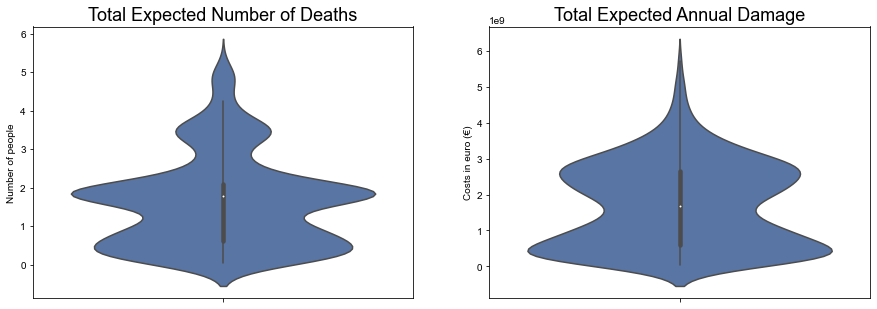

In [14]:
# plotting the number of deaths and the damage costs (aggregated over time and location)

#set the size of the figure
f, axes = plt.subplots(1, 2, figsize=(15,5))
sns.set(style="whitegrid", font_scale=1.5)
plt.rcParams["axes.labelsize"] = 15

sns.violinplot(data=df_aggregate["Total Expected Number of Deaths"], ax=axes[0])
sns.violinplot(data=df_aggregate["Total Expected Annual Damage"], ax=axes[1])

#layout of the plots
axes[0].set_title("Total Expected Number of Deaths")
axes[0].set_ylabel('Number of people')
axes[0].set(xticklabels = [])

axes[1].set_title("Total Expected Annual Damage")
axes[1].set_ylabel('Costs in euro (€)')
axes[1].set(xticklabels = [])

plt.show()

Conclusion

We see that a number of scenarios score low Expected number of Deaths, but there are also a lot of scenarios which score high. Everything above 2 people we consider high.
Looking at total annual damage, we see that there are also some low scoring scenarios but also a lot of high scoring ones. We see that at 2.5e+09 the tip of the violin starts. Let's check which percentages of scenarios score this high.

In [15]:
#Check which percentage of scenarios score high on both objectives.

total= df_aggregate["Total Expected Number of Deaths"].count()
print("Total number of scenarios is", total, "scenarios.")
count_total_death = df_aggregate["Total Expected Number of Deaths"][df_aggregate["Total Expected Number of Deaths"]>2].count()
print(count_total_death, "is", count_total_death/total, "% of", total, "scenarios score higher than 2 people")
count_total_damage = df_aggregate["Total Expected Annual Damage"][df_aggregate["Total Expected Annual Damage"]>2500000000].count()
print(count_total_damage, "is", count_total_damage/total, "% of", total, "scenarios score higher than 2.5e+09 euro's.")

Total number of scenarios is 985 scenarios.
262 is 0.265989847715736 % of 985 scenarios score higher than 2 people
294 is 0.2984771573604061 % of 985 scenarios score higher than 2.5e+09 euro's.


Conclusion

So a lot of scenarios are located in the top 27/30%. Let's check whether this is for each location as well, or if it differs per location.
The number of deaths and annual damage for Dike Ring 1 are also objectives for our case, so that is why we are choosing to dissaggregate over location (and not time).

#### 2.2.2 Secondly, The Expected Number of Deaths for each location

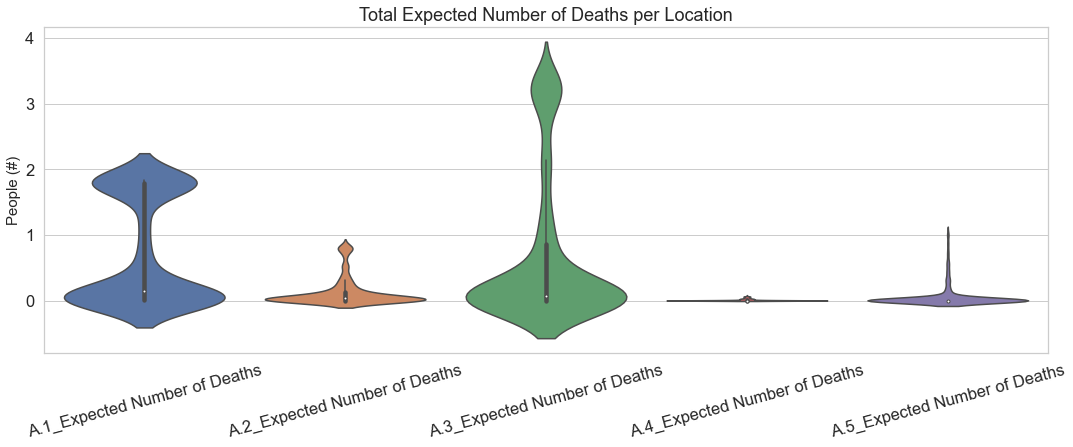

In [16]:
#aggregated over time, so for each location
df_location_deaths=aggregate_df(outcomes)
outcomes_of_interest1 = ["A.1_Expected Number of Deaths", "A.2_Expected Number of Deaths","A.3_Expected Number of Deaths", "A.4_Expected Number of Deaths", "A.5_Expected Number of Deaths"]
df_location_deaths = df_location_deaths[outcomes_of_interest1]

#set the size of the figure
f, axes = plt.subplots(1, 1, figsize=(18,6))
sns.set(style="whitegrid", font_scale=1.5)

#load in the dataframe
sns.violinplot(data=df_location_deaths, ax=axes, scale='count')
plt.xticks(rotation=15)
plt.rcParams["axes.labelsize"] = 18

#label axes
axes.set_ylabel('People (#)')
axes.set_title("Total Expected Number of Deaths per Location")

plt.show()

A lot of scenarios which score high and low for A.1 and A.3. Let's look for objectives A1 Damage

#### 2.2.3 Thirdly, we are looking at the Annual Damage per location

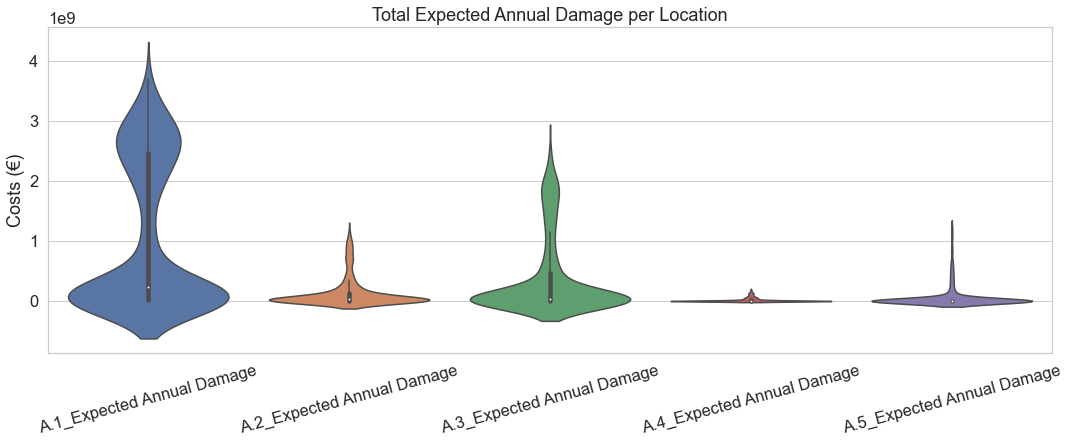

In [17]:
#aggregated over time, so for each location
df_location_damage=aggregate_df(outcomes)
outcomes_of_interest2 = ["A.1_Expected Annual Damage", "A.2_Expected Annual Damage","A.3_Expected Annual Damage", "A.4_Expected Annual Damage", "A.5_Expected Annual Damage"]
df_location_damage = df_location_damage[outcomes_of_interest2]

#set the size of the figure
f, axes = plt.subplots(1, 1, figsize=(18,6))
sns.set(style="whitegrid", font_scale=1.5)

#load in the dataframe
sns.violinplot(data=df_location_damage, ax=axes, scale='count')
plt.xticks(rotation=15)
plt.rcParams["axes.labelsize"] = 18

#label axes
axes.set_ylabel('Costs (€)')
axes.set_title("Total Expected Annual Damage per Location")

plt.show()

We see here that in Dike Ring 1 and Dike Ring 3, there are again a lot scenarios which score high and a lot of scenarios which score low. 

Since 2 of our objectives are number of deaths and expected annual damage for Dike Ring 1, let's check which percentage of scenarios score high.

In [18]:
total_count= df_aggregate["A.1_Expected Number of Deaths"].count()

#We look at figure "Total Expected Number of Deaths per Location"
#We see that in the first violin "A.1_Expected Number of Deaths" the top bulk starts around 1.5
#Therefore we will check which percentage is in the top bulk
count_death = df_aggregate["A.1_Expected Number of Deaths"][df_aggregate["A.1_Expected Number of Deaths"] > 1.5].count()
percentage_death=count_death/total_count

#We look at figure "Total Expected Annual Damage per Location"
#We see that in figure violin "A.1_Expected Annual Damage" the top bulk starts at around 2e+09
#Therefore we will check which percentage is in the top bulk
count_damage = df_aggregate["A.1_Expected Annual Damage"][df_aggregate["A.1_Expected Annual Damage"] > 2000000000].count()
percentage_damage=count_damage/total_count

print("Total amount of scenarios is", total_count)
print("For number of deaths:", count_death, "scenarios score above 1.5 people, which is", percentage_death, "% of total scenarios")
print("For annual damage:", count_damage, "scenarios score above 2e+09, which is", percentage_damage, "% of total scenarios")

Total amount of scenarios is 985
For number of deaths: 347 scenarios score above 1.5 people, which is 0.3522842639593909 % of total scenarios
For annual damage: 325 scenarios score above 2e+09, which is 0.3299492385786802 % of total scenarios


## 3. Searching for the worst scenarios based on the effect of the uncertainties

### 3.1 Establishing the threshold

Now that we understand that for A.1_Expected Number of Deaths, A.1_Expected Annual Damage, Total Number of Deaths and Total Annual Damage there are a number of scenarios which score very high. (These are 4 of our 5 objectives, A.1_Dike Investment Costs will not be considered since we are working with the base case, no policies). 

We call the scenarios which exceed the threshold we have established, worst case scenarios.

In [19]:
# Save the value as True or False if the value exceeds the treshold
threshold = pd.DataFrame()
threshold["Death_threshold"] = df_aggregate["Total Expected Number of Deaths"] > 2
threshold["Damage_threshold"] = df_aggregate["Total Expected Annual Damage"] > 2500000000

threshold["A.1_Death_threshold"] = df_aggregate["A.1_Expected Number of Deaths"] > 1.5
threshold["A.1_Damage_threshold"] = df_aggregate["A.1_Expected Annual Damage"] > 2000000000

# If both values are above the threshold than set True in worst case boolean series
worst_cases_totals = threshold["Death_threshold"] & threshold["Damage_threshold"]
worst_cases_A1 =threshold["A.1_Death_threshold"]&threshold["A.1_Damage_threshold"]

#If all values are above the threshold set True
worst_case_scenarios=worst_cases_totals & worst_cases_A1
#worst_case_scenarios.to_csv('../final assignment/results/boolean_worst_scenario_all.csv')

In [20]:
# Since we are not using policies, we can delete all inputs about dike increases, RfR and evacuation time
new_experiments = experiments.iloc[:,:19]
new_experiments.head()

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2
0,19,93.023790,1.5,0.748883,263.404585,10.0,0.273062,176.767531,10.0,0.578308,133.005763,1.0,0.792671,213.412932,10.0,0.949322,4.5,2.5,3.5
1,123,101.422013,1.5,0.138024,210.856574,1.0,0.059383,152.325470,1.0,0.117431,285.872685,1.0,0.077937,292.243986,10.0,0.401123,3.5,4.5,3.5
2,7,304.143707,10.0,0.337110,275.749497,1.5,0.930965,205.923257,1.0,0.466004,71.456906,1.0,0.294562,42.163356,1.0,0.027539,2.5,2.5,2.5
3,43,336.283665,1.5,0.544184,328.636942,1.5,0.346368,199.235476,10.0,0.653444,49.671142,1.5,0.479646,67.694873,1.0,0.324707,1.5,2.5,1.5
4,45,312.289962,1.0,0.978617,211.533047,1.0,0.252732,121.743473,1.0,0.748695,118.751766,10.0,0.128881,285.608062,1.5,0.337620,3.5,2.5,4.5


#### 3.2 Finding the 5 worst case reference scenarios for the **Outcome DataFrame**

In this paragraph, we will determine the 5 worst case scenarios of the base case. These worst case scenarios are based on the objectives: "A.1_Expected Annual Damage", "A.1_Dike Investment Costs", "A.1_Expected Number of Deaths", "Total Expected Number of Deaths" and "Total Expected Annual Damage". 

Again, the other objective hasn't outcomes yet, since there are no policies yet implemented.

We are finding the 5 worst case scenarios on the **outcome dataframe**, because we can compare the outcomes that uncertainties-combination (scenario) had. 


In [21]:
#The True/False dataframes we have are:
worst_cases_totals
worst_cases_A1
worst_case_scenarios #this one has 4 thresholds

# Make the dataframe a list
worst_case_list_totals = np.array(worst_cases_totals).squeeze() #using squeeze to remove the brackets
worst_case_list_A1 = np.array(worst_cases_A1).squeeze() #using squeeze to remove the brackets
worst_case_list= np.array(worst_case_scenarios).squeeze() #using squeeze to remove the brackets

We will continue with **worst_case_scenarios, so scenarios which exceed the 4 thresholds**,  since we do not want to exceed the threshold for any of the 4 objectives

In [22]:
# Only work with the experiments and the outcomes that are above the threshold (so the worst cases)
experiments_above_threshold = experiments.loc[worst_case_list]

#make the outcomes DataFrame
outcomes_above_threshold = pd.DataFrame({key:value[worst_case_list] for key,value in outcomes.items()})

In [23]:
#aggretate over time, per location
d3_aggregate_exp=aggregate_df(outcomes_above_threshold)

In [24]:
#Choosing our objectives as the outcomes
#Dike investment Costs of Dike Ring 1 should be zero since no policies are yet implemented in the basecase
df_objectives = d3_aggregate_exp[outcomes_objectives]
df_objectives

,A.1_Expected Annual Damage,A.1_Dike Investment Costs,A.1_Expected Number of Deaths,Total Expected Number of Deaths,Total Expected Annual Damage
1,2.148814e+09,0,1.834596,4.069313,3.423863e+09
13,2.178517e+09,0,1.805946,2.137414,2.515213e+09
29,3.039581e+09,0,1.785498,2.409437,3.489968e+09
32,3.191960e+09,0,1.798284,2.087497,3.454420e+09
36,2.630173e+09,0,1.746643,4.747858,4.464765e+09
...,...,...,...,...,...
962,2.172220e+09,0,1.799394,2.628754,2.571465e+09
966,2.758565e+09,0,1.783054,2.086902,2.940018e+09
967,2.807891e+09,0,1.823200,2.079944,3.116492e+09
974,3.063316e+09,0,1.803056,4.836143,5.138343e+09


In [25]:
# We sort each column to find the worst cases of each column
df_sort = pd.DataFrame()
for column in df_objectives.columns:
    df_sort[column] = df_objectives[column].rank()

#Then we create a new column which gets the sum value of all the columns
#Therefore you can compare the columns
#And find the worst cases
df_sort['Sum ranking'] = df_sort.sum(axis=1) #axis 1 because we want to add all the values in each row
df_sort

,A.1_Expected Annual Damage,A.1_Dike Investment Costs,A.1_Expected Number of Deaths,Total Expected Number of Deaths,Total Expected Annual Damage,Sum ranking
1,2.0,42.0,82.5,58.0,35.0,219.5
13,4.0,42.0,45.0,13.0,1.0,105.0
29,67.0,42.0,20.5,30.0,42.0,201.5
32,78.0,42.0,35.0,10.0,41.0,206.0
36,35.0,42.0,4.0,65.0,70.0,216.0
...,...,...,...,...,...,...
962,3.0,42.0,36.5,44.0,3.0,128.5
966,44.0,42.0,18.0,9.0,17.0,130.0
967,55.0,42.0,71.0,8.0,21.0,197.0
974,69.5,42.0,40.5,70.0,80.0,302.0


In [26]:
# Then we sort the ranking dataframe to find the 5 worst case scenarios
df_worst_cases = df_sort.sort_values(by='Sum ranking',ascending=False) #ascending false because we want the highest values first
df_5_worst_cases=df_worst_cases.head(5) #we only want the worst 5

#Find the indexes of those scenarios (keep in mind that this is the index of the aggegrated dataframe of the experiments above the threshold)
df_5_worst_id = list(df_5_worst_cases.index)
df_5_worst_id


[389, 519, 541, 335, 974]

In [27]:
#Create a outcomes dataframe that contains the 5 worst cases
df_scenarios_outcomes=df_objectives.loc[[389, 519, 541, 335, 974]]
df_scenarios_outcomes

,A.1_Expected Annual Damage,A.1_Dike Investment Costs,A.1_Expected Number of Deaths,Total Expected Number of Deaths,Total Expected Annual Damage
389,3.140929e+09,0,1.825323,4.980270,5.349766e+09
519,2.821894e+09,0,1.834596,4.806822,4.683804e+09
541,2.930145e+09,0,1.812074,5.109685,5.112206e+09
335,3.202786e+09,0,1.805946,4.352027,5.012169e+09
974,3.063316e+09,0,1.803056,4.836143,5.138343e+09


#### 3.3 Finding the index of the 5 worst case reference scenarios for the **Experiments DataFrame**

Since the experiments dataframe will tell us what the uncertainties of these 5 worst scenarios are.

In [28]:
df_scenarios_experiments = experiments_above_threshold.loc[[389, 519, 541, 335, 974],:]

In [29]:
#We only want the first 19 columns of the experiment dataframe (these are the uncertainties)
df_scenarios_experiments=df_scenarios_experiments.iloc[:, :19]
df_scenarios_experiments

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2
389,112,76.539055,1.5,0.005280,118.386904,1.0,0.359809,209.556219,1.5,0.040066,122.305318,1.5,0.823036,349.115851,1.5,0.015937,2.5,2.5,1.5
519,123,186.582908,1.0,0.124598,341.713134,1.5,0.814515,141.797954,1.0,0.002934,49.084925,10.0,0.504394,74.998111,10.0,0.090257,2.5,4.5,1.5
541,121,44.976172,1.0,0.154180,315.527619,10.0,0.278339,320.949897,1.0,0.028642,126.594441,1.5,0.999996,246.041200,1.0,0.526665,3.5,2.5,1.5
335,127,98.612264,1.5,0.304277,49.174700,1.5,0.582915,76.144141,1.5,0.119453,234.760282,1.0,0.652885,178.009828,1.0,0.789073,3.5,1.5,1.5
974,15,116.453125,1.5,0.330338,191.666985,10.0,0.674579,308.936390,1.5,0.064977,51.506522,1.5,0.499539,211.661021,1.0,0.050274,1.5,1.5,4.5


In [30]:
# Make a list for each scenarios so that we can work with them later in the optimalization
scenarios = [Scenario(f"{index}", **row) for index, row in df_scenarios_experiments.iterrows()]

## 4. Performing Optimalisation with the 5 worst case scenarios

For MORDM do we need to formulate our problem (see section 1). A new file (problem_formulation_modified.py) was created for that reason. We needed to assess the min max values under which we can perform MORDM.
After that we can run the optimization

### 4.1 Find the min and max values

In [31]:
experiments2, outcomes2 = load_results('../final assignment/results/policies_fully_disaggregated.tar.gz') 
df2_outcomes = pd.DataFrame.from_dict(outcomes2)

[MainProcess/INFO] results loaded successfully from C:\Users\31649\Documents\Master\Model-based decisionmaking\epa1361_open-master\final assignment\results\policies_fully_disaggregated.tar.gz


In [32]:
#Make the DataFrame for our five objectives for the base case WITH POLICIES
df2_aggregate=aggregate_df(df2_outcomes)
df2_aggregate = df2_aggregate[outcomes_objectives]

In [33]:
#find the min and max values for the base case WITH and WITHOUT polices
max_nopol = df_aggregate.max()
min_nopol = df_aggregate.min()

max_pol = df2_aggregate.max()
min_pol = df2_aggregate.min()

In [34]:
#Pick the most extreem value from both base cases
max_of_range = pd.concat([max_nopol, max_pol], axis=1) #axis = 1 because we want the two options PER objective (instead of everything in one column)
min_of_range = pd.concat([min_nopol, min_pol], axis=1)

max_of_range = max_of_range.max(axis=1) #of both options, we want the highest of each objective
min_of_range = min_of_range.min(axis=1)#of both options, we want the lowest of each objective

In [35]:
outcome_ranges=pd.concat([max_of_range, min_of_range], axis=1)
outcome_ranges.rename(columns = {0:'Max_values', 1:'Min_values'}, inplace = True)
outcome_ranges

,Max_values,Min_values
A.1_Expected Annual Damage,3.694513e+09,0.0
A.1_Dike Investment Costs,3.753980e+08,0.0
A.1_Expected Number of Deaths,1.834596e+00,0.0
Total Expected Number of Deaths,5.276779e+00,0.0
Total Expected Annual Damage,5.736794e+09,0.0


In [36]:
outcome_ranges.to_csv("outcome_ranges_fenna.csv")

In [37]:
from ema_workbench.em_framework.optimization import HyperVolume, EpsilonProgress
max_vals=[]
max_vals=[outcome_ranges.iloc[4,0],outcome_ranges.iloc[3,0],outcome_ranges.iloc[0,0],outcome_ranges.iloc[1,0],outcome_ranges.iloc[2,0]]
max_vals

[5736794173.005579,
 5.276778645570779,
 3694513006.6833086,
 375398028.08627385,
 1.8345956996319948]

### 4.2 Find the list of epsilons

In [38]:
df_epsilon=aggregate_df(df2_outcomes)
outcomes_objectives = ["Total Expected Annual Damage","Total Expected Number of Deaths","A.1_Expected Annual Damage","A.1_Dike Investment Costs",\
                        "A.1_Expected Number of Deaths"]
df_epsilon = df_epsilon[outcomes_objectives]

In [39]:
#Define the values for epsilon
list_epsilons=[]
for column in df_epsilon.columns:
    new_df = df_epsilon[df_epsilon[column] >0] # we do not want epsilons that are zero
    epsilon=min(new_df[column]) #we want the smallest epsilon (apart from 0)
    list_epsilons.append(epsilon)

In [40]:
list_epsilons

[51545.63341453237,
 3.942122931196812e-06,
 425513.8617408112,
 82486364.23710208,
 4.8454387049822016e-05]

### 4.3 Run the Optimization

In [41]:
#Import the old and new problemformultion
from problem_formulation import get_model_for_problem_formulation
from problem_formulation_modified1 import get_model_for_problem_formulation_modified

In [42]:
dike_model,  planning_steps = get_model_for_problem_formulation_modified(outcome_ranges)
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [ ]:
ema_logging.log_to_stderr(ema_logging.INFO)

# The HyperVolume measore describes the volume of the space Hypervolume space
convergence_metrics = [HyperVolume.from_outcomes(dike_model.outcomes),
                       EpsilonProgress()]

nfe = 2000
results_list = []
convergence_list = []

for scenario in scenarios:
    with MultiprocessingEvaluator(dike_model) as evaluator:
        results_runs, convergence = evaluator.optimize(nfe=nfe, searchover='levers',
                                        epsilons=list_epsilons,
                                        convergence=convergence_metrics, reference=scenario)
                                        
        
        results_list.append(results_runs)
        convergence_list.append(convergence)


In [ ]:
#Save the list of results_list
l = results_list
with open("results/pickle_results_list_2000nfe", "wb") as fp:   #Pickling
    pickle.dump(l, fp)

In [ ]:
#Save the list of convergence_list

n = convergence_list
with open("results/pickle_convergence_list_2000nfe"", "wb") as fp:   #Pickling
    pickle.dump(n, fp)

In [43]:
#load in both lists
with open("results/pickle_results_list_2000nfe", "rb") as fp:   # Unpickling
    results_list = pickle.load(fp)

with open("results/pickle_convergence_list_2000nfe", "rb") as fp:   # Unpickling
    convergence_list = pickle.load(fp)

### 4.4 Plotting the Optimization

According to the workbench, an important part of using many-objective evolutionary algorithms is to carefully monitor whether they have converged.

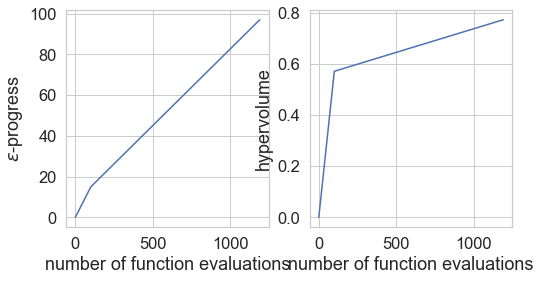

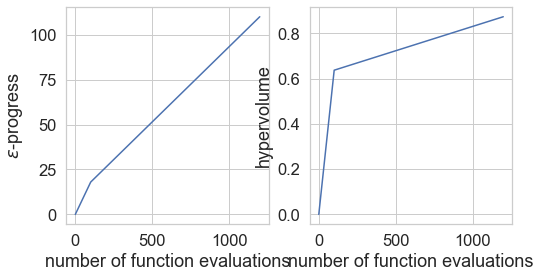

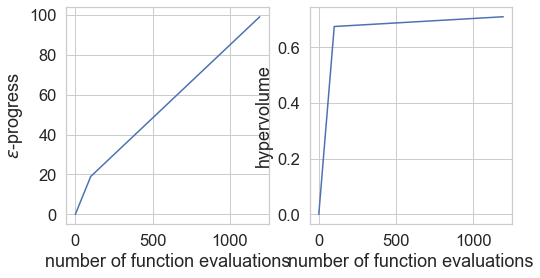

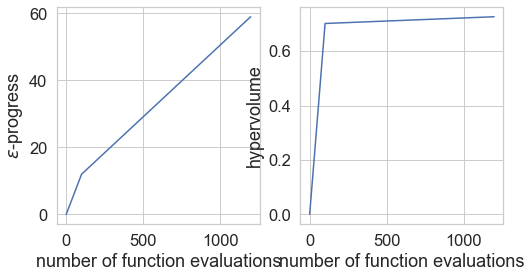

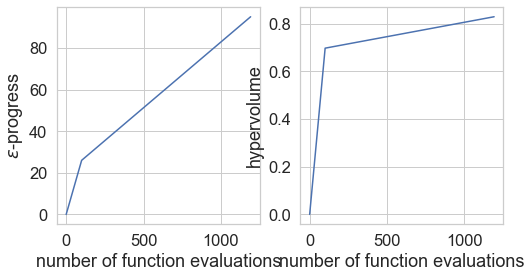

In [44]:
#For each scenario epsilon-progress and hypervolume, side by side comparison
for convergence in convergence_list:
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8, 4))
    ax1.plot(convergence.nfe, convergence.epsilon_progress)
    ax1.set_ylabel("$\epsilon$-progress")
    ax2.plot(convergence.nfe, convergence.hypervolume)
    ax2.set_ylabel("hypervolume")

    ax1.set_xlabel("number of function evaluations")
    ax2.set_xlabel("number of function evaluations")
    plt.show()

In [47]:
#To check whether the right scenarios where used
df_5_worst_id

[389, 519, 541, 335, 974]

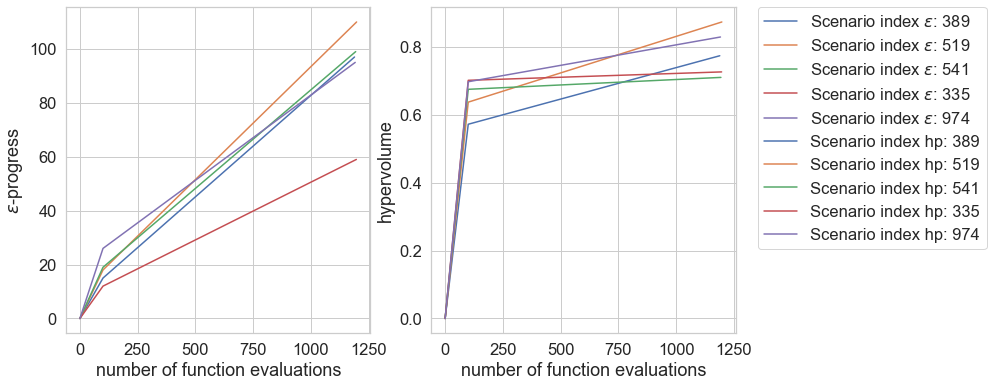

In [48]:
#Put together in one graph to compare the scenarios
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(12,6))

for i, convergence in enumerate(convergence_list):
    ax1.plot(convergence['nfe'], convergence['epsilon_progress'], label=f'Scenario index $\epsilon$: {df_5_worst_id[i]}')
    ax2.plot(convergence['nfe'], convergence['hypervolume'], label=f'Scenario index hp: {df_5_worst_id[i]}')
    
ax1.set_ylabel('$\epsilon$-progress')    
ax2.set_ylabel('hypervolume')


ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')

fig.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9))
plt.show()

Epsilon progress has a little bit converged, except for one.The hypervolume metric has almost converged. So the ranges in the hypervolume metric where sufficient. 

We see that the epsilon progress is not really stabilized. So next time, the optimalization can be run with a larger number of funtion evaluation. Due to time limiation, we assume that the solutions found, are the optimized solutions.

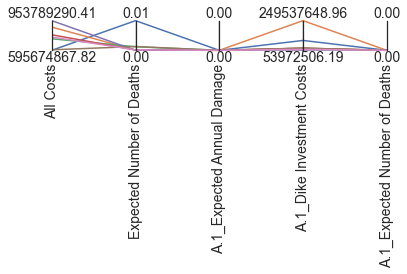

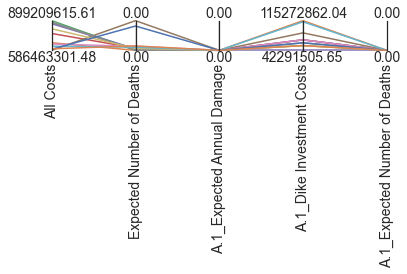

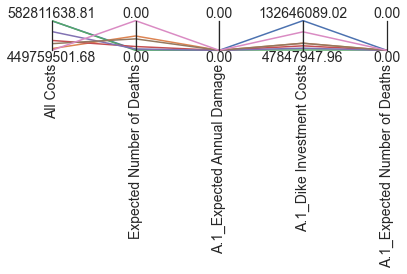

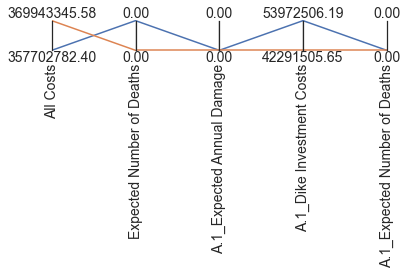

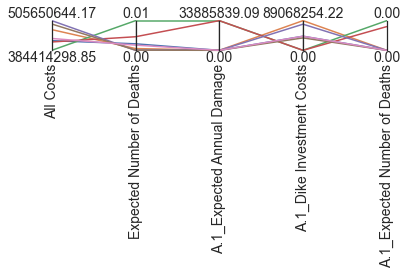

In [50]:
from ema_workbench.analysis import parcoords

for results_runs in results_list:
    data = results_runs.loc[:, [o.name for o in dike_model.outcomes]]
    limits = parcoords.get_limits(data)
    # limits.loc[0, list(df_rp.columns)] = 0

    paraxes = parcoords.ParallelAxes(limits)
    paraxes.plot(data)
    plt.show()